In [2]:
import os
import numpy as np


def find_best(checkpoint, task):
    log_files_a = os.listdir(checkpoint+"/")
    log_files_b = []

    for file in log_files_a:
        file_split = file.split(".")
        if(file_split[-1]=="txt"):
            file_split_2 = file_split[0].split("_")
            if(file_split_2[0]=="session" and file_split_2[1]==str(task) ):
                f = np.loadtxt(checkpoint+"/"+file, skiprows=1)
                best_acc = max(f[-1,-1], f[-1,-2])
                if(file_split_2[-1]!="RT"):
                    return best_acc
                    
    return best_acc


In [3]:
##### import numpy as np
from collections import Counter

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def get_mata_score(p, task, chunks):
    
    task_samples = {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 500, 16: 500, 17: 500, 18: 500, 19: 500}
    total_samples = np.sum([task_samples[x] for x in range(task+1)])
    classes_per_task = 5
    with open(p + "/meta_task_test_list_"+str(task)+".pickle", 'rb') as handle:
        acc_task = pickle.load(handle)
        
#     for x in range(2110,2120):
#         print(x, acc_task[x][0][-1], acc_task[x][1][-1])
    correct = 0
    correct2= 0
    for tt in range(task+1):
        ctask_samples = np.sum([task_samples[x] for x in range(tt)])
        start_point = ctask_samples
        for class_id in range(task_samples[tt]//chunks):

            task_scores = []
            task_scores2 = []
            class_scores = []
            class_scores_base = []
            targets = []
            for t in range(task+1):
                list_1 = []
                list_2 = []
                list_3 = []
                list_4 = []
                for i in range(chunks):
                    acc_task_0 = acc_task[class_id*chunks+i + start_point]
                    list_1.append(acc_task_0[t][0].detach().cpu().numpy())
#                     list_2.append(acc_task_0[t][1].detach().cpu().numpy())
                    list_2.append(acc_task_0[t][1][t*classes_per_task:(t+1)*classes_per_task].detach().cpu().numpy())
                    list_4.append(acc_task_0[t][2].detach().cpu().numpy())
                    list_3.append(acc_task_0[t][3].detach().cpu().numpy())
                list_1 = np.array(list_1)
                list_2 = np.array(list_2)
                list_3 = np.array(list_3)
                list_4 = np.array(list_4)

                task_scores.append(list_4)
                class_scores.append(list_2)
                targets.append(list_3)


            m = task_scores[0]
            task_scores2 = []
            for t2 in range(task+1):
#                 mx = softmax(m)
                m2 = m[:,t2*classes_per_task:(t2+1)*classes_per_task]
#                 m3 = np.max(m2, 1)
                
                mi = np.argsort(m2, 1)
                mj = mi[:, ::-1][:,:1]
                m3 = np.take_along_axis(m2, mj, axis=1)

                task_scores2.append(np.mean(m3))
            
            pred_task = np.argmax(task_scores2)
#             pred_task = tt
            if(pred_task == tt):
                correct2 += chunks
                for j in range(chunks):
                    pred_x = np.argsort(class_scores[pred_task][j])[::-1][0:1]
                    target_x = targets[0][j]
                    if(target_x in pred_x+pred_task*classes_per_task):
                        correct += 1 
#             else:
#                 print(pred_task, tt, task_scores2)


#             pred_task = np.argmax(task_scores2)  
#             if(pred_task == tt):
#                 correct2 += chunks
#                 for j in range(chunks):
#                     pred_x = np.argmax(class_scores[pred_task][j])
#                     target_x = targets[0][j]
#                     if(pred_x+pred_task*10==target_x):
#                         correct += 1 
                        
        
        task_scores = []
        task_scores2 = []
        class_scores = []
        class_scores_base = []
        targets = []
        
        new_chunk = task_samples[tt]-(class_id+1)*chunks
        if(new_chunk>0):
            for t in range(task+1):
                list_1 = []
                list_2 = []
                list_3 = []
                list_4 = []
                for i in range(task_samples[tt]-(class_id+1)*chunks):
                    acc_task_0 = acc_task[((task_samples[tt]//chunks)*chunks)+i]
                    list_1.append(acc_task_0[t][0].detach().cpu().numpy())
#                     list_2.append(acc_task_0[t][1].detach().cpu().numpy())
                    list_2.append(acc_task_0[t][1][t*classes_per_task:(t+1)*classes_per_task].detach().cpu().numpy())
                    list_4.append(acc_task_0[t][2].detach().cpu().numpy())
                    list_3.append(acc_task_0[t][3].detach().cpu().numpy())
                list_1 = np.array(list_1)
                list_2 = np.array(list_2)
                list_3 = np.array(list_3)
                list_4 = np.array(list_4)

                task_scores.append(list_4)
                class_scores.append(list_2)
                targets.append(list_3)

            m = task_scores[0]
            task_scores2 = []
            for t2 in range(task+1):
#                 print(m.shape, t2*classes_per_task,(t2+1)*classes_per_task)

                m2 = m[:,t2*classes_per_task:(t2+1)*classes_per_task]
    #             m2 = softmax(m[:,t2*2:(t2+1)*2])
                m3 = np.max(m2, 1)
                task_scores2.append(np.mean(m3))

            pred_task = np.argmax(task_scores2)
            if(pred_task == tt):
                correct2 += new_chunk
                for j in range(chunks):
                    pred_x = np.argsort(class_scores[pred_task][j])[::-1][0:1]
                    target_x = targets[0][j]
                    if(target_x in pred_x+pred_task*classes_per_task):
                        correct += 1
            
                        
                        

    return correct/total_samples*100, correct2/total_samples*100

# get_mata_score("models/cifar100/meta2_cifar_T20_8",15, 20)            



In [9]:
models_dic = [
#     ["results/cifar100/meta_twohead_T20_1",       "m",          "base 17M, meta 17M, ex=2000, gamma=3",       "o-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_2",       "green",          "base 17M, meta 17M, ex=2000, gamma=1, b=0.2",       "o-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_3",       "gold",          "base 11M, meta 17M, ex=2000, gamma=1, b=auto",       "<-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_4",       "orange",          "base 11M, meta 17M, ex=2000, gamma=1, b=auto",       "<-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_5",       "black",          "base 11M, meta 17M, ex=2000, gamma=1, b=auto",       "<-"   ], #todo
    
    
    ["results/cifar100/meta_cifar_T20_0",       "black",          "base 1.25M, ex=2000, gamma=1, b=auto",       "<-"   ], #todo
    
    
    ["results/cifar100/meta_cifar_T20_2",       "m",          "base 1.25M, ex=250, gamma=1, b=auto",       "<-"   ], #todo
#     ["results/cifar100/meta_cifar_T20_3",       "brown",          "ours",       "D-"   ], #todo
#     ["results/cifar100/meta_cifar_T20_4",       "brown",          "ours",       "D-"   ], #todo
#     ["results/cifar100/meta_cifar_T20_5",       "brown",          "base 1.25M, ex=1300b, gamma=1, b=auto",       "D-"   ], #todo
    
    
#     ["results/cifar100/meta2_cifar_T20_6",       "brown",          "base 1.25M, ex=2000b, reptile",       "D-"   ], #todo
#     ["results/cifar100/meta2_cifar_T20_7",       "brown",          "base 1.25M, ex=2000b, reptile",       "D-"   ], #todo
    ["results/cifar100/meta2_cifar_T20_8",       "g",          "base 1.25M, ex=2000b, reptile",       "D-"   ], #todo
    
]


90,89,90,90,90,90,90,89,87,88,88,87,83,81,79,82,80,81,81,80
92.0,81.2,86.4,85.55,87.56,86.3333,84.0286,85.55,85.5111,85.3,84.8727,84.9,84.6462,83.9857,78.68,82.0125,81.1529,81.9222,83.0947,79.4
91.4,91.8,92.3333,91.45,91.16,90.0,90.2286,88.05,86.9556,85.44,85.6545,84.0333,79.0923,77.2571,72.68,70.0,69.9059,70.0556,71.8421,70.53


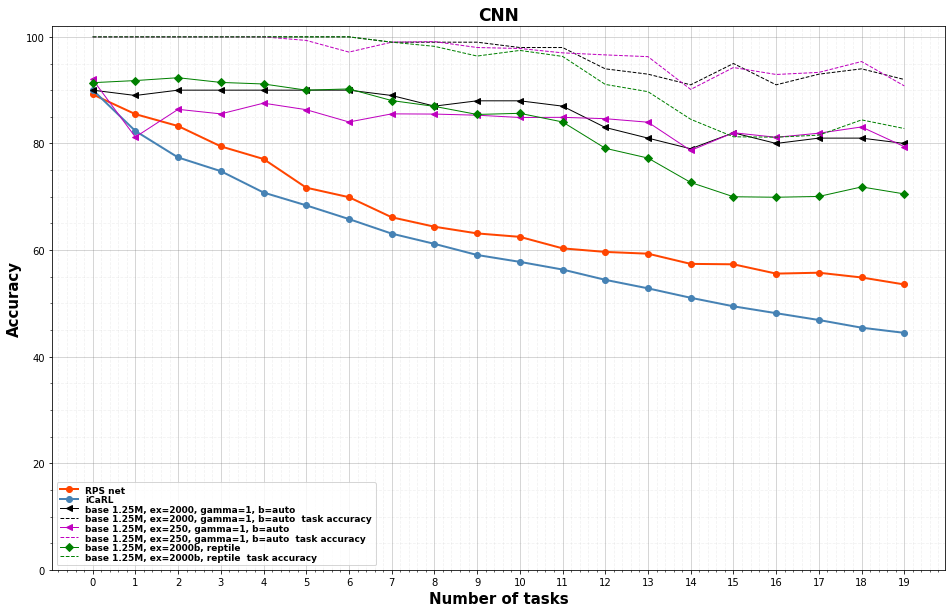

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
x = range(20)

icarl = [90.05,82.34,77.37,74.80,70.79,68.38,65.81,63.08,61.16,59.07,57.78,56.34,54.41,52.81,51.04,49.44,48.15,46.87,45.43,44.46]
ours = [89.2,85.5,83.266666,79.45,77.08,71.7,69.914286,66.15,64.377778,63.12,62.472727,60.316667,59.646154,59.314286,57.4,57.325,55.576471,55.744444,54.852632,53.54]



plt.figure(figsize=(16,10))

chunks = 20

plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="RPS net")
plt.plot(x, icarl, "o-", linewidth=2, c="steelblue", label="iCaRL")

for i,p in enumerate(models_dic):
    z = np.zeros_like(list(x))*0.0
    z2 = np.zeros_like(list(x))*0.0
    ps = "models/" + "/".join(p[0].split("/")[1:])
    try:
        z = np.load(p[0]+"/meta_"+str(chunks)+".npy")
        z2 = np.load(p[0]+"/meta_task_"+str(chunks)+".npy")
        if(np.sum(z>0)<20):
            for j in range(np.sum(z>0), len(icarl)):
                try:
                    z[j], z2[j] = get_mata_score(ps , j, chunks)
                except Exception as e:
                    pass
            np.save(p[0]+"/meta_"+str(chunks)+".npy", z)
            np.save(p[0]+"/meta_task_"+str(chunks)+".npy", z2)
    except:
        for j in range(20):
            try:
                z[j], z2[j] = get_mata_score(ps , j, chunks)
            except Exception as e:
                pass
        np.save(p[0]+"/meta_"+str(chunks)+".npy", z)
        np.save(p[0]+"/meta_task_"+str(chunks)+".npy", z2)
        
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    plt.plot(x, z2, "--", linewidth=1, c = p[1], label=p[2] + "  task accuracy")
    
    print(",".join([str(np.around(i,4)) for i in z]) )

plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,102])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("CNN", fontweight='bold', fontsize=17) 
plt.xticks(range(20))
# plt.savefig("plot_data/meta_20.pdf")
plt.show()


[0.834, 0.908, 0.866, 0.84, 0.93, 0.8, 0.848, 0.888, 0.778, 0.922, 0.886, 0.898, 0.874, 0.832, 0.85, 0.846, 0.898, 0.848, 0.918, 0.938]
[0.832, 0.882, 0.876, 0.822, 0.926, 0.814, 0.83, 0.884, 0.83, 0.922, 0.908, 0.908, 0.91, 0.836, 0.856, 0.86, 0.916, 0.834, 0.92, 0.93]
[0.804, 0.858, 0.866, 0.822, 0.932, 0.774, 0.842, 0.85, 0.78, 0.91, 0.878, 0.872, 0.878, 0.82, 0.82, 0.852, 0.88, 0.798, 0.888, 0.922]


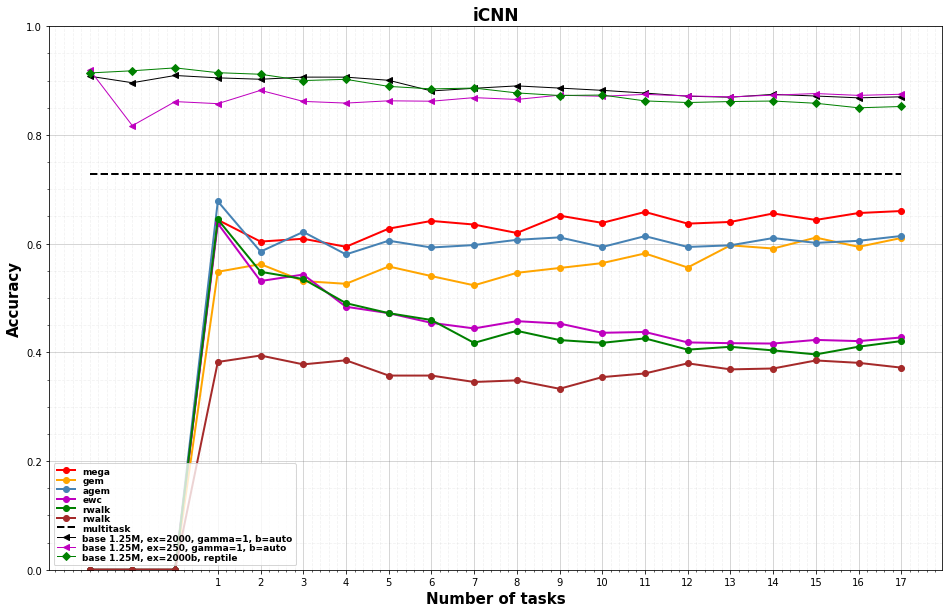

In [8]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
x = range(-2,18)

mega = [0,0,0,0.6437,0.6038,0.609,0.5942,0.6276,0.6418,0.6351,0.6196,0.6515,0.6382,0.6583,0.6368,0.6399,0.6555,0.6436,0.6563,0.66]
gem = [0,0,0,0.5482,0.5623,0.5312,0.5261,0.558,0.5403,0.5233,0.5463,0.5552,0.5642,0.582,0.5561,0.5969,0.591,0.6111,0.5941,0.6104]
agem =  [0,0,0,0.6778,0.5853,0.6216,0.5802,0.6054,0.5929,0.5974,0.607,0.6115,0.5938,0.6138,0.5939,0.5969,0.6103,0.6014,0.6052,0.6141]
ewc = [0,0,0,0.6371,0.5312,0.5431,0.4839,0.4721,0.4543,0.444,0.4574,0.453,0.436,0.4375,0.4183,0.4169,0.4162,0.4229,0.4207,0.4274]
rwalk = [0,0,0,0.6445,0.5482,0.5349,0.4905,0.4721,0.4595,0.4174,0.4396,0.4226,0.4175,0.4257,0.405,0.4102,0.4036,0.3962,0.4104,0.4208]
mer = [0,0,0,0.3823,0.3942,0.3779,0.3854,0.3573,0.3573,0.3455,0.3485,0.333,0.3545,0.3612,0.3798,0.3687,0.3703,0.3851,0.3807,0.3719]
# multitask = [0.6847]*20
multitask = [0.728]*20


plt.figure(figsize=(16,10))

# plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="ours")
plt.plot(x, mega, "o-", linewidth=2, c="red", label="mega")
plt.plot(x, gem, "o-", linewidth=2, c="orange", label="gem")
plt.plot(x, agem, "o-", linewidth=2, c="steelblue", label="agem")
plt.plot(x, ewc, "o-", linewidth=2, c="m", label="ewc")
plt.plot(x, rwalk, "o-", linewidth=2, c="green", label="rwalk")
plt.plot(x, mer, "o-", linewidth=2, c="brown", label="rwalk")
plt.plot(x, multitask, "--", linewidth=2, c="black", label="multitask")

for i,p in enumerate(models_dic):
    z = np.zeros((20,))*0.0
    ps = "models/" + "/".join(p[0].split("/")[1:])
    for j in range(0,20):
        try:
            with open(ps + "/acc_task_"+str(j)+".pickle", 'rb') as handle:
                acc_task = pickle.load(handle)
            if(j==19):
                print([np.around(x/100,4) for x in acc_task.values()])
#             print(acc_task)
            z[j] = np.sum([acc_task[x] for x in range(j+1)])/(j+1)/100.0
#             z[j] = acc_task[j]
        except Exception as e:
#             print(e)
            pass
#     print(",".join([str(i) for i in z]) )
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    
plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,1])
# plt.xlim([0.97,17.2])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("iCNN", fontweight='bold', fontsize=17) 
plt.xticks(range(1,18))
# plt.savefig("reptile.pdf")
plt.show()

In [183]:
a = np.zeros((10,))
print(a[:100])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


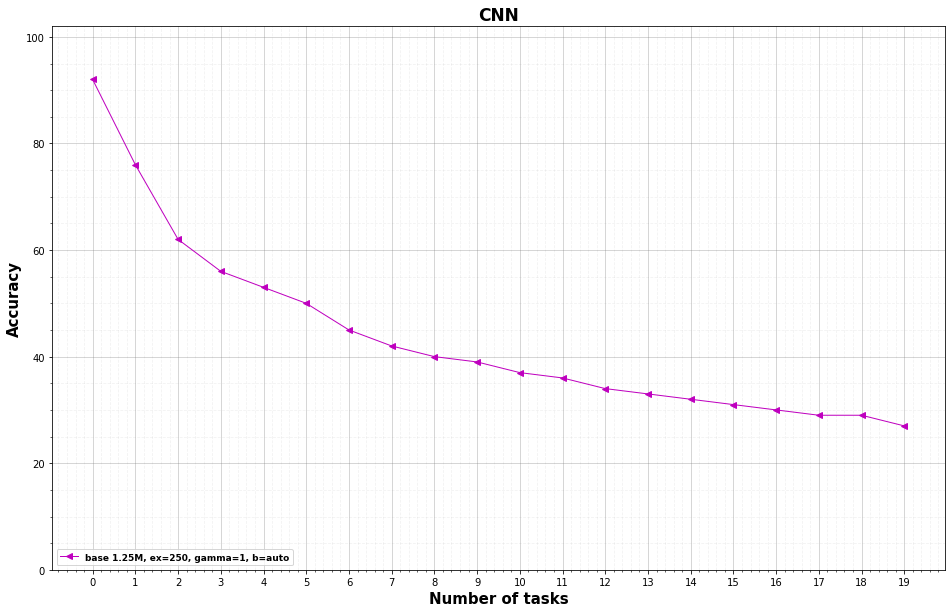

In [386]:
import matplotlib.pyplot as plt 
import numpy as np
x = range(20)
# icarl = [88.5, 78.39, 72.34, 66.94, 63.50, 60.23, 56.63, 54.17, 51.23, 49.10]
# ours = [88.8, 81.3, 77.266667, 72.575, 67.98, 66.0, 64.328571, 62.1, 59.744444, 57.36]

# models_dic = [
#     ["results/cifar100/meta_twohead_T20_1",       "brown",          "base 17M, meta 17M, ex=2000, gamma=3",       "o-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_2",       "g",          "base 17M, meta 17M, ex=2000, gamma=3, b=0.2",       "o-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_3",       "gold",          "base 11M, meta 17M, ex=2000, gamma=3, b=0.2",       "<-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_4",       "orange",          "base 11M, meta 17M, ex=2000, gamma=1, b=auto",       "<-"   ], #todo
# #     ["results/cifar100/meta_twohead_T20_5",       "black",          "base 11M, meta 17M, ex=2000, gamma=1, b=auto",       "<-"   ], #todo
    
# ]

plt.figure(figsize=(16,10))

# plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="ours")
# plt.plot(x, icarl, "o-", linewidth=2, c="steelblue", label="iCaRL")

for i,p in enumerate(models_dic):
    z = np.zeros_like(list(x))
    for j in range(len(list(x))):
        
        try:
            z[j] = find_best(p[0], j)

        except Exception as e:
#             print(e)
            pass
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    
plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,102])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("CNN", fontweight='bold', fontsize=17) 
plt.xticks(range(20))
# plt.savefig("reptile.pdf")
plt.show()

In [53]:
a = np.load("results/cifar100/meta_5/seed.npy")
print(a)

9984
